In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import os
import pandas as pd

/tmp/ipykernel_1269902/3408467763.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
datasets = ['books', 'history', 'fb', 'osm']
# colors = ['#4E79A7', '#F28E2B', '#59A14F', '#E15759']
colors = ['red', 'orange', 'green', 'blue']

build_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'build')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

/tmp/ipykernel_1269902/2359551292.py:7: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, header=None)
/tmp/ipykernel_1269902/2359551292.py:7: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, header=None)
/tmp/ipykernel_1269902/2359551292.py:7: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, header=None)
/tmp/ipykernel_1269902/2359551292.py:7: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, header=None)


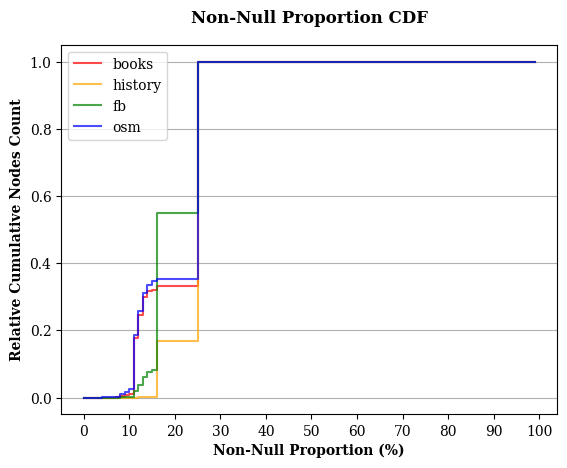

In [4]:
csv_file_names = [os.path.join(build_path, f'{dataset}.csv') for dataset in datasets]

plt.figure()

for i, file_name in enumerate(csv_file_names):
    try:
      df = pd.read_csv(file_name, header=None)
    except Exception as e:
      continue

    total_count = len(df)
    total_values = df.iloc[2:, 0].astype(float)
    null_values = df.iloc[2:, 1].astype(float)
    non_null_percentages = ((total_values - null_values) / total_values) * 100
    percent_intervals = np.arange(0, 101, 1)
    counts, _ = np.histogram(non_null_percentages, bins=percent_intervals)
    counts = np.asarray(counts) / total_count
    cumulative_counts = np.cumsum(counts)

    plt.plot(percent_intervals[:-1], cumulative_counts,
             drawstyle='steps-post', color=colors[i % len(colors)], alpha=0.7, label=file_name.split('/')[-1].split('.')[0])

plt.xlabel('Non-Null Proportion (%)', fontdict={'weight': 'bold'})
plt.ylabel('Relative Cumulative Nodes Count', fontdict={'weight': 'bold'})
plt.xticks(np.arange(0, 101, 10))
plt.grid(axis='y')
plt.legend()
plt.title('Non-Null Proportion CDF', fontdict={'weight': 'bold'}, pad=16)
plt.show()

NameError: name 'to_k' is not defined

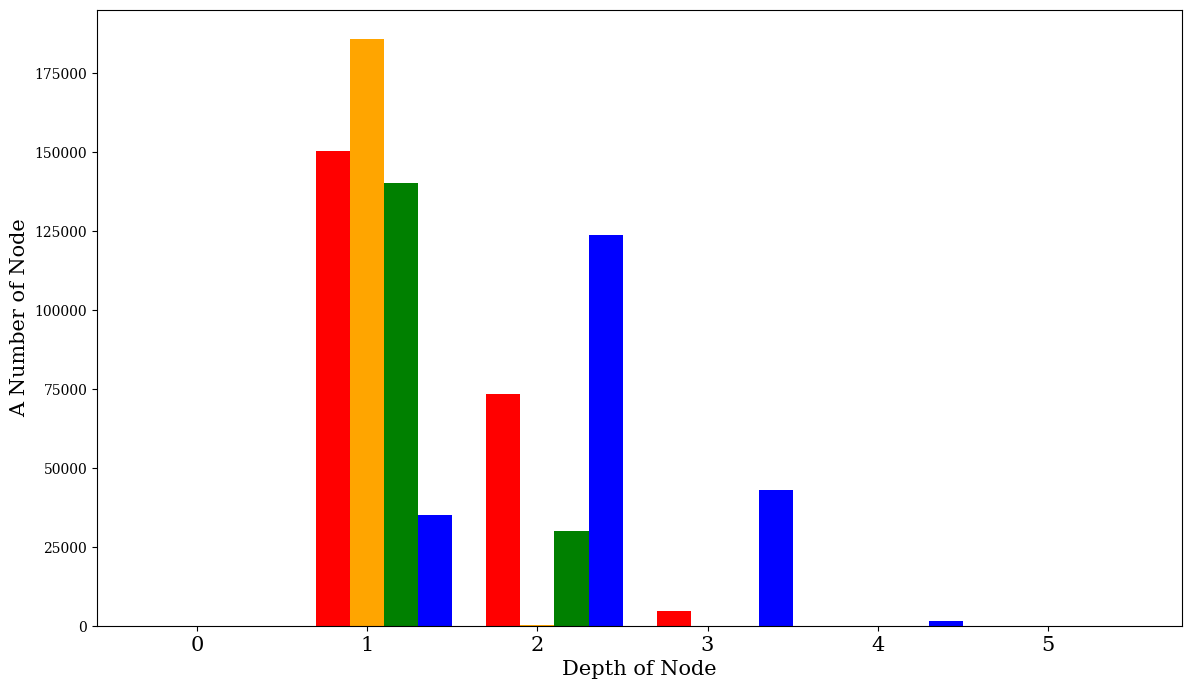

In [5]:
csv_file_names = [os.path.join(build_path, f'{dataset}.csv') for dataset in datasets]

# 각 파일의 데이터를 저장할 빈 DataFrame 생성
df_combined = pd.DataFrame()

# 각 파일에 대해 반복하여 데이터 처리
for i, file_name in enumerate(csv_file_names):
    df = pd.read_csv(file_name)
    # 'depth' 별로 개수를 계산하고 DataFrame으로 변환
    depth_counts = df['depth'].value_counts().sort_index().rename_axis('depth').reset_index(name=f'counts_{i}')
    # 병합된 DataFrame에 추가
    if df_combined.empty:
        df_combined = depth_counts
    else:
        df_combined = pd.merge(df_combined, depth_counts, on='depth', how='outer')

# NaN 값을 0으로 채움
df_combined.fillna(0, inplace=True)

# 그래프 그리기
plt.figure(figsize=(14, 8))
bar_width = 0.2  # 막대 너비
indices = np.arange(len(df_combined['depth']))  # depth 값의 개수에 따른 인덱스 배열

for i in range(len(csv_file_names)):
    plt.bar(indices + i * bar_width, df_combined[f'counts_{i}'], width=bar_width, color=colors[i], label=datasets[i])

plt.xlabel('Depth of Node', fontsize=15)
plt.ylabel('A Number of Node', fontsize=15)
plt.title('', fontsize=15, fontweight='bold')
plt.xticks(indices + bar_width, df_combined['depth'], fontsize=15)

# y축 값을 K 단위로 설정
formatter = FuncFormatter(to_k)
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(fontsize=15)
plt.tight_layout()
plt.show()


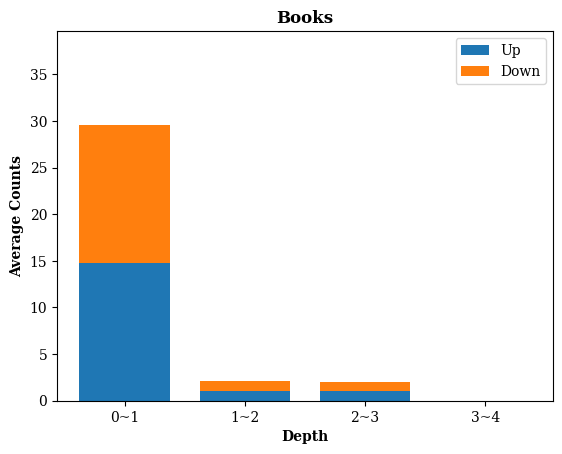

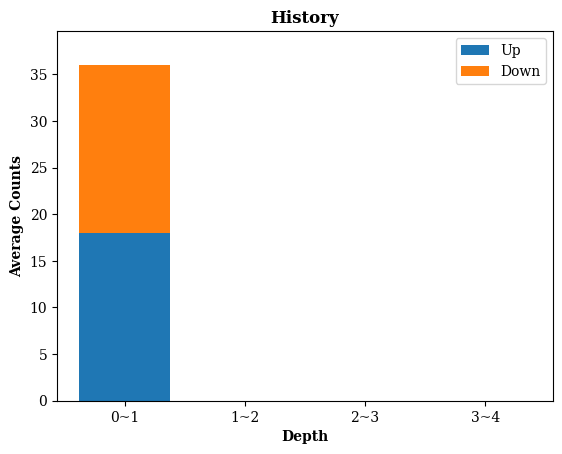

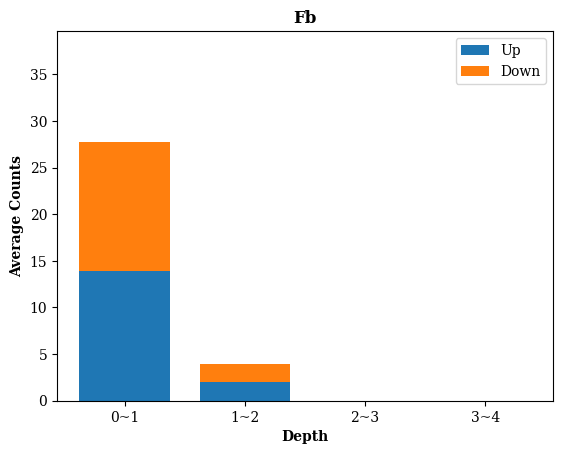

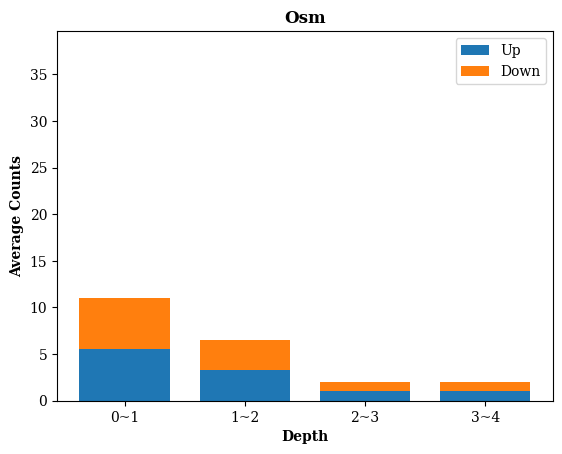

In [ ]:
csv_file_names = [os.path.join(build_path, f'{dataset}_count.csv') for dataset in datasets]

all_depths = set()

for file_name in csv_file_names:
    df = pd.read_csv(file_name)
    for depth, _, _ in df.itertuples(index=False):
        try:
            all_depths.add(int(depth))
        except ValueError:
            continue

all_depths = sorted(all_depths)

averages = np.arange(len(csv_file_names), dtype=object)
global_ups_downs = []

for i, file_name in enumerate(csv_file_names):
    depth_data = {}
    df = pd.read_csv(file_name)
    
    for depth, up, down in df.itertuples(index=False):
        try:
            depth = int(depth)
        except ValueError:
            continue
            
        if depth not in depth_data:
            depth_data[depth] = {'up': [], 'down': []}
        depth_data[depth]['up'].append(up)
        depth_data[depth]['down'].append(down)

    averages[i] = {depth: {'up': np.mean(info['up']), 'down': np.mean(info['down'])} for depth in all_depths for info in [depth_data.get(depth, {'up': [0], 'down': [0]})]}
    global_ups_downs.extend([averages[i][depth]['up'] + averages[i][depth]['down'] for depth in all_depths])

y_min = min(global_ups_downs)
y_max = max(global_ups_downs)

for i, file_name in enumerate(csv_file_names):
    ups = [averages[i][depth]['up'] for depth in all_depths]
    downs = [averages[i][depth]['down'] for depth in all_depths]

    fig, ax = plt.subplots()
    bar_width = 0.3
    index = np.arange(len(all_depths)) * (bar_width + 0.1)
    xlabels = [f'{int(depth)}~{int(depth) + 1}' for depth in all_depths]

    ax.bar(index, ups, bar_width, label='Up')
    ax.bar(index, downs, bar_width, bottom=ups, label='Down')

    ax.set_xlabel('Depth', fontdict={'weight': 'bold'})
    ax.set_ylabel('Average Counts', fontdict={'weight': 'bold'})
    ax.set_title(datasets[i][:1].upper() + datasets[i][1:], fontdict={'weight': 'bold'})
    ax.set_xticks(index)
    ax.set_xticklabels(xlabels)
    ax.set_ylim([y_min, y_max * 1.1])
    ax.legend(loc='upper right')

    plt.show()

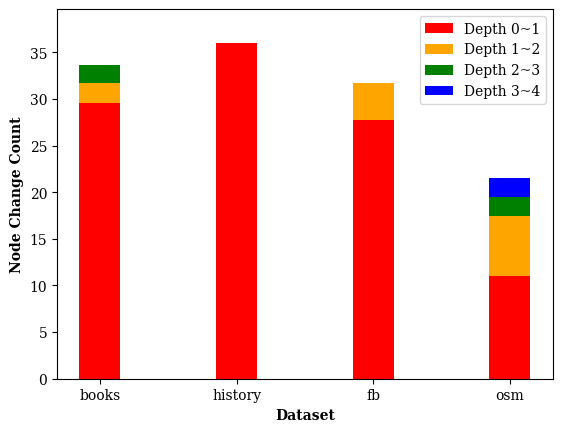

In [ ]:
csv_file_names = [os.path.join(build_path, f'{dataset}_count.csv') for dataset in datasets]

depth_totals = {}

for dataset, file_name in zip(datasets, csv_file_names):
    df = pd.read_csv(file_name)
    depth_totals[dataset] = {}

    for depth, up, down in df.itertuples(index=False):
        try:
            depth = int(depth)
        except ValueError:
            continue

        depth = str(depth)
        total = up + down
        
        if depth in depth_totals[dataset]:
            depth_totals[dataset][depth].append(total)
        else:
            depth_totals[dataset][depth] = [total]

dataset_avgs = {dataset: {depth: np.mean(totals) for depth, totals in depths.items()} for dataset, depths in depth_totals.items()}

all_depths = sorted({depth for depths in depth_totals.values() for depth in depths.keys()})

fig, ax = plt.subplots()
index = np.arange(len(datasets))
bar_width = 0.3

bottoms = np.zeros(len(datasets))
for depth in all_depths:
    avgs = [dataset_avgs[dataset].get(depth, 0) for dataset in datasets]
    ax.bar(index, avgs, bar_width, bottom=bottoms, color=colors[all_depths.index(depth) % len(colors)], label=f'Depth {depth}~{int(depth) + 1}')
    bottoms += np.array(avgs)

y_max = max(bottoms)

ax.set_xlabel('Dataset', fontdict={'weight': 'bold'})
ax.set_ylabel('Node Change Count', fontdict={'weight': 'bold'})
ax.set_xticks(index)
ax.set_xticklabels(datasets)
ax.set_ylim([0, y_max * 1.1])
ax.legend()

plt.show()

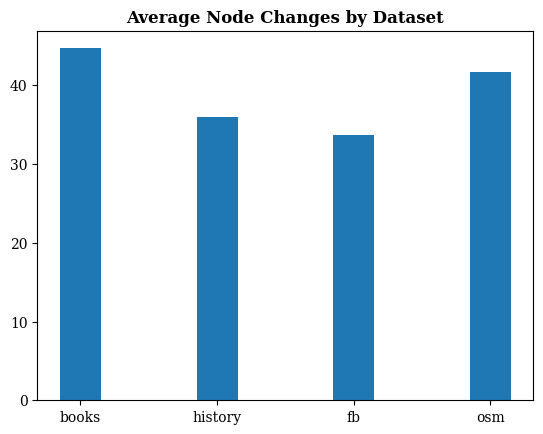

In [ ]:
csv_file_names = [os.path.join(build_path, f'{dataset}_count.csv') for dataset in datasets]

averages = []

for i, file_name in enumerate(csv_file_names):
    idx = 0
    data = []
    df = pd.read_csv(file_name)
    
    for depth, up, down in df.itertuples(index=False):
        try:
            int(depth)
            if len(data) <= idx:
                data.append(up + down)
            else:
                data[idx] += up + down
        except ValueError:
            idx += 1
    
    avg = np.mean(data) if data else float('nan')
    averages.append(avg)

fig, ax = plt.subplots()
ax.bar(datasets, averages, 0.3)
ax.set_title('Average Node Changes by Dataset', fontdict={'weight': 'bold'})
plt.show()